In [1]:
from micromet.volk import get_contour_levels
%matplotlib inline
import os

import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import pyproj
import pyproj as proj
from fluxdataqaqc import Data
from rasterio.plot import show
import xarray as xr
import rioxarray
#from rio.crs import CRS
from micromet import improved_ffp as ffp

import logging
###############################################################################
# Configure logging
###############################################################################
logger = logging.getLogger(__name__)

# Create timestamp index for 24 hours with 30-min intervals
timestamps = pd.date_range('2024-01-01', '2024-01-02', freq='30min')
n_samples = len(timestamps)

# Set up reproducible random state
np.random.seed(42)

# Calculate split sizes that sum to n_samples
split_size = n_samples // 3
remainder = n_samples % 3
splits = [split_size + (1 if i < remainder else 0) for i in range(3)]

# Modified test data with more realistic ranges
# Create test data with parameters more likely to produce realistic footprint extents
test_data = {
    'wd': np.linspace(0, 360, n_samples),
    # Further increase wind speeds
    'ws': 5 + np.random.rand(n_samples) * 5,  # 5-10 m/s
    # Increase friction velocity for more turbulent conditions
    'USTAR': 0.4 + np.random.rand(n_samples) * 0.6,  # 0.4-1.0 m/s
    'V_SIGMA': 0.8 + np.random.rand(n_samples) * 0.7,  # 0.8-1.5 m/s
    'MO_LENGTH': np.concatenate([
        # More pronounced stability ranges
        -1000 + np.random.rand(splits[0]) * 900,  # Unstable: -1000 to -100
        -20000 + np.random.rand(splits[1]) * 40000,  # Near neutral with wider range
        100 + np.random.rand(splits[2]) * 900  # Stable: 100 to 1000
    ])
}

# Create DataFrame
df = pd.DataFrame(test_data, index=timestamps)
df = df.sample(frac=1).sort_index()

# Initialize FFP model with adjusted parameters
test_ffp = ffp.FFPModel(
    df=df,
    domain=[-2000, 2000, -2000, 2000],  # Even larger domain
    dx=10,  # Larger grid spacing for computational efficiency
    dy=10,
    crop_height=1.0,  # Higher vegetation
    inst_height=20.0,  # Much higher measurement height
    atm_bound_height=1000.0,
    smooth_data=True,
    rs=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # For contour plotting
)

# Run model
results = test_ffp.run()


KeyError: 'WD'

In [1]:
"""
Example usage of FFPModel with US-CRT data.

This script demonstrates how to use the FFPModel class with the US-CRT AmeriFlux site data.
"""

import pandas as pd
import configparser
from micromet.improved_ffp import FFPModel
import matplotlib.pyplot as plt

def load_config(config_file):
    """Load and parse the configuration file."""
    config = configparser.ConfigParser()
    config.read(config_file)
    return config

def load_data(csv_file):
    """Load data from CSV file."""
    # Read CSV file
    df = pd.read_csv(csv_file, skiprows=2, nrows=240)
    return df


# Load configuration and data
config = load_config('US-CRT_config.ini')
df = load_data('AMF_US-CRT_BASE_HH_3-5.csv')

# Get site parameters from config
lat = float(config['METADATA']['station_latitude'])
lon = float(config['METADATA']['station_longitude'])

# Set up model parameters
params = {
    'domain': [-200, 200, -200, 200],  # Smaller domain for example
    'dx': 3.0,  # 2m resolution
    'dy': 3.0,
    'crop_height': 0.2,  # From metadata - alfalfa crop height
    'inst_height': 5.0,  # Standard EC measurement height
    'atm_bound_height': 2000.0,  # Typical daytime boundary layer height
    'rs': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],  # Source area fractions
    'smooth_data': True,
    'crop': False,
    'verbosity': 2
}

# Initialize FFP model
print("Initializing FFP model...")
ffp = FFPModel(df, **params)

# Run the model
print("Running footprint calculations...")
results = ffp.run()

# Create visualization
plt.figure(figsize=(12, 8))

# Plot footprint climatology
plt.contourf(
    results.domain_x,
    results.domain_y,
    results.footprint_climatology,
    levels=20,
    cmap='YlOrRd'
)

# Add contours for source areas
for r in params['rs']:
    area_key = f'r_{int(r * 100)}'
    if area_key in results:
        area = results[area_key]
        contour = area['contour']
        plt.contour(
            contour.x,
            contour.y,
            contour.f,
            levels=[float(contour.contour_level)],
            colors='k',
            linewidths=0.5
        )

# Add receptor location
plt.plot(0, 0, 'r*', markersize=10, label='Tower')

# Customize plot
plt.colorbar(label='Flux footprint')
plt.xlabel('Distance [m]')
plt.ylabel('Distance [m]')
plt.title(f'Flux Footprint - {config["METADATA"]["site_name"]}')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.legend()

# Save results
results.to_netcdf('us_crt_footprint.nc')
plt.savefig('us_crt_footprint.png', dpi=300, bbox_inches='tight')
plt.close()

print("Footprint analysis completed. Results saved to us_crt_footprint.nc")
print("Footprint visualization saved to us_crt_footprint.png")



2025-01-19 18:20:02,357 - FFPModel - DEBUG - Valid input length: 139
2025-01-19 18:20:02,359 - FFPModel - INFO - Mean RSL height (z*): 0.7m, Measurement height: 2.0m
2025-01-19 18:20:02,360 - FFPModel - INFO - Setting up computational domain...
2025-01-19 18:20:02,361 - FFPModel - DEBUG - Domain dimensions - x: 201, y: 201


Initializing FFP model...


2025-01-19 18:20:02,594 - FFPModel - DEBUG - Grid shapes - xv: (201, 201), rho: (201, 201)
2025-01-19 18:20:02,595 - FFPModel - INFO - Domain setup completed successfully
2025-01-19 18:20:02,643 - FFPModel - INFO - strongly_unstable: 0 points (0.0%)
2025-01-19 18:20:02,644 - FFPModel - INFO - unstable: 16 points (11.5%)
2025-01-19 18:20:02,645 - FFPModel - INFO - neutral: 112 points (80.6%)
2025-01-19 18:20:02,646 - FFPModel - INFO - stable: 11 points (7.9%)
2025-01-19 18:20:02,647 - FFPModel - INFO - strongly_stable: 0 points (0.0%)
2025-01-19 18:20:02,650 - FFPModel - INFO - Starting FFP model calculations...
2025-01-19 18:20:02,651 - FFPModel - INFO - Starting footprint calculation...
2025-01-19 18:20:02,664 - FFPModel - DEBUG - Rotated theta shape: (201, 201, 139)
2025-01-19 18:20:02,670 - FFPModel - DEBUG - Stability regime counts - Stable: 84, Unstable: 0, Neutral: 55
2025-01-19 18:20:02,671 - FFPModel - DEBUG - Initializing arrays with shape: x=201, y=201
2025-01-19 18:20:02,802

Running footprint calculations...


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis12\Lib\site-packages\xarray\core\computation.py:831: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
2025-01-19 18:20:03,113 - FFPModel - DEBUG - x_star_modified shape: (201, 201, 139)
2025-01-19 18:20:03,125 - FFPModel - DEBUG - x_star_modified range: -inf to inf
2025-01-19 18:20:03,126 - FFPModel - DEBUG - f_star shape: (201, 201, 139)
2025-01-19 18:20:03,136 - FFPModel - DEBUG - f_star range: 0.0 to 0.30883125477938794
2025-01-19 18:20:03,140 - FFPModel - DEBUG - crosswind_integrated_footprint statistics:
2025-01-19 18:20:03,142 - FFPModel - DEBUG -   Shape: (201, 201, 139)
2025-01-19 18:20:03,171 - FFPModel - DEBUG -   NaN count: <xarray.DataArray ()> Size: 8B
array(0)
2025-01-19 18:20:03,175 - FFPModel - DEBUG -   Min: 0.0
2025-01-19 18:20:03,181 - FFPModel - DEBUG -   Max: 0.30883125477938794
2025-01-19 18:20:03,216 - FFPModel - DEBUG -   Mean: 0.000556815898826999
C:\Users\paulinkenbrandt\Anaconda3\envs\p

Footprint analysis completed. Results saved to us_crt_footprint.nc
Footprint visualization saved to us_crt_footprint.png


2025-01-19 18:20:18,121 - FFPModel - DEBUG - Domain shapes - x: 201, y: 201
2025-01-19 18:20:18,122 - FFPModel - DEBUG - Footprint climatology shape: (201, 201)
2025-01-19 18:20:18,125 - FFPModel - DEBUG - Footprint climatology stats - min: 0.0, max: 0.005204067821305111
2025-01-19 18:20:18,194 - FFPModel - DEBUG - Domain shapes - x: 201, y: 201
2025-01-19 18:20:18,195 - FFPModel - DEBUG - Footprint climatology shape: (201, 201)
2025-01-19 18:20:18,197 - FFPModel - DEBUG - Footprint climatology stats - min: 0.0, max: 0.005204067821305111
2025-01-19 18:20:18,255 - FFPModel - DEBUG - Domain shapes - x: 201, y: 201
2025-01-19 18:20:18,256 - FFPModel - DEBUG - Footprint climatology shape: (201, 201)
2025-01-19 18:20:18,257 - FFPModel - DEBUG - Footprint climatology stats - min: 0.0, max: 0.005204067821305111
2025-01-19 18:20:18,418 - FFPModel - DEBUG - Domain shapes - x: 201, y: 201
2025-01-19 18:20:18,418 - FFPModel - DEBUG - Footprint climatology shape: (201, 201)
2025-01-19 18:20:18,420

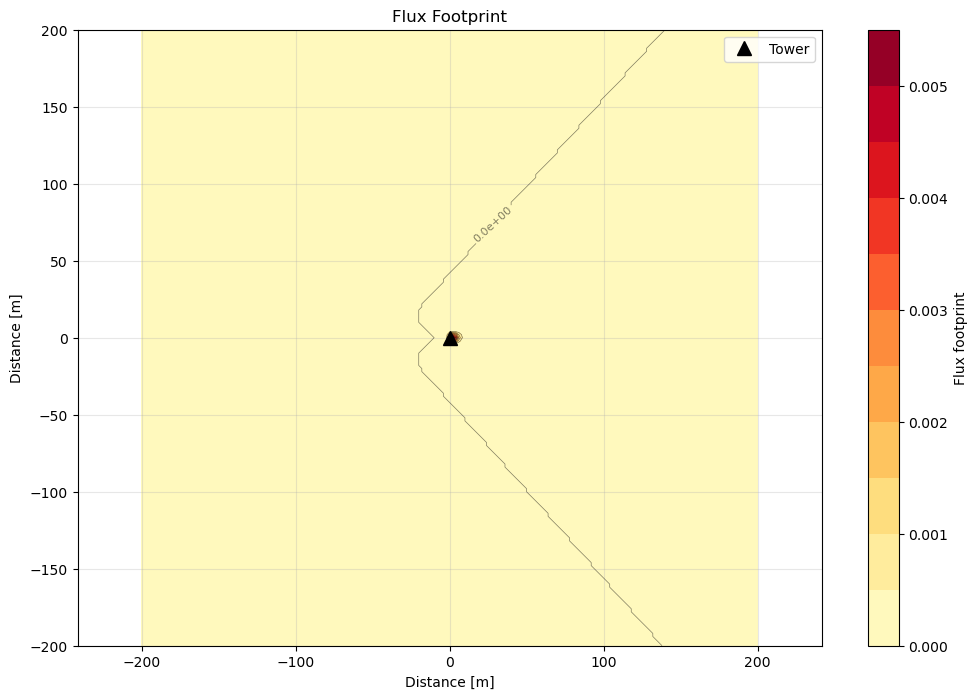

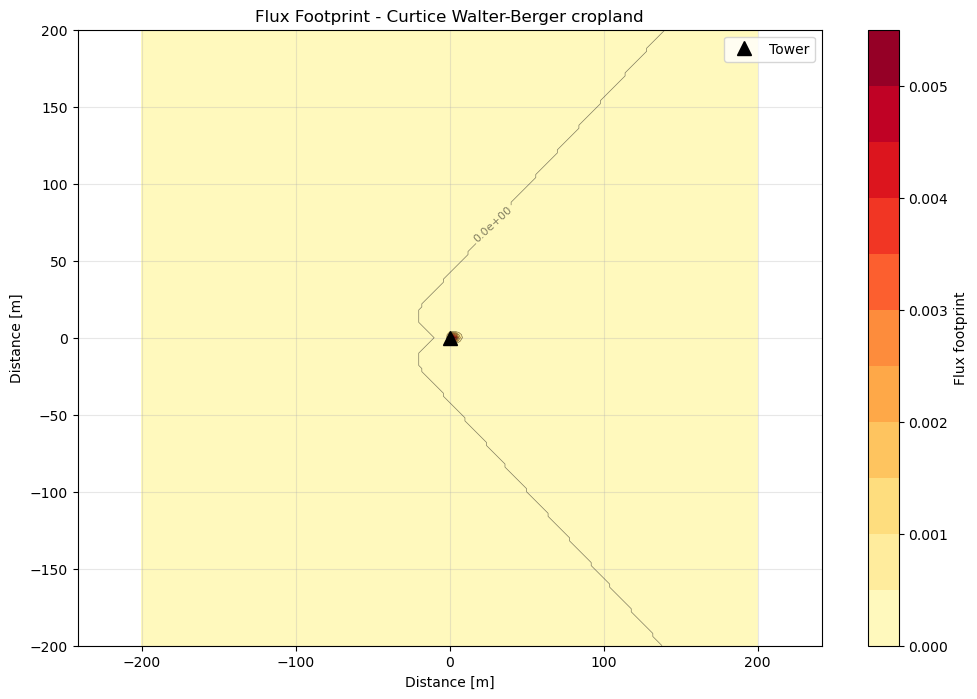

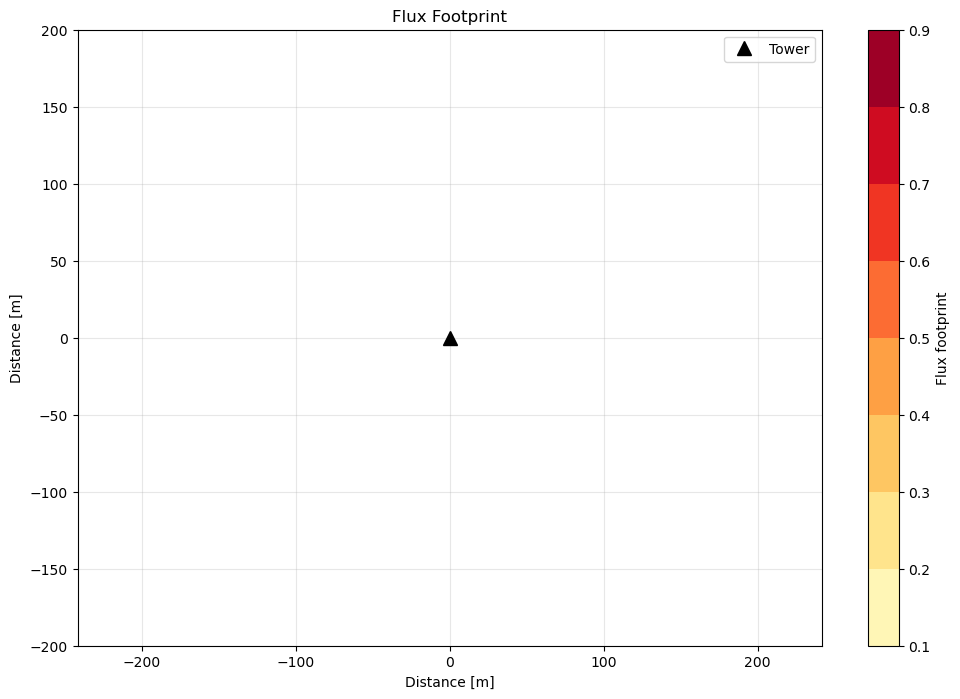

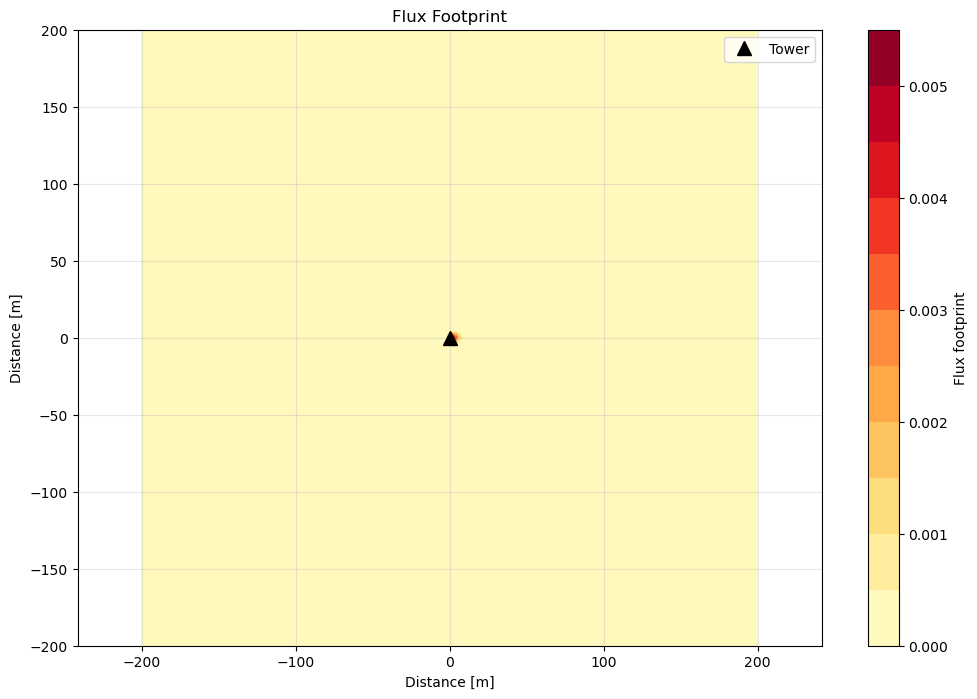

In [2]:
# Basic usage
fig, ax = ffp.plot_footprint()

# With config
fig, ax = ffp.plot_footprint(config=config)

# With custom contour levels
fig, ax = ffp.plot_footprint(levels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# Without contour lines
fig, ax = ffp.plot_footprint(show_contours=False)

In [3]:
import pandas as pd
csv_file = 'AMF_US-CRT_BASE_HH_3-5.csv'
df = pd.read_csv(csv_file, skiprows=2, nrows=240 )
df

,TIMESTAMP_START,TIMESTAMP_END,CO2,H2O,FC,NEE_PI,CH4,FCH4,H,LE,...,CO2_PI_1,CO2_PI_2,SWC_PI_1,SWC_PI_2,SW_DIF,PPFD_OUT,APAR,PPFD_DIF,FAPAR,VPD_PI
0,201101010000,201101010030,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999.0,-9999.0,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
1,201101010030,201101010100,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999.0,-9999.0,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2,201101010100,201101010130,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999.0,-9999.0,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
3,201101010130,201101010200,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999.0,-9999.0,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
4,201101010200,201101010230,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999.0,-9999.0,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,201101052130,201101052200,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999.0,-9999.0,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
236,201101052200,201101052230,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999.0,-9999.0,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
237,201101052230,201101052300,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999.0,-9999.0,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
238,201101052300,201101052330,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999.0,-9999.0,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
